## Generating a Temporal model (Sinusodial case)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
#from astropy.coordinates import (AltAz, EarthLocation)
from astropy.time import Time
from regions import CircleSkyRegion

from gammapy.modeling.models import LightCurveTemplateTemporalModel

import logging

log = logging.getLogger(__name__)



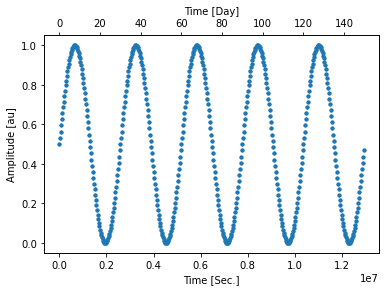

In [8]:
#Temporal profile to be injected
def my_sin(t, freq, amplitude, phase, offset):
    return np.sin(t * freq + phase) * amplitude + offset

N = 100 # number of data points
freq = 1/30.0  #period = 30 days
tmax=2*np.pi/freq  #2*pi*T
t = np.linspace(0, tmax, N)
y = my_sin(t, freq, 0.5, 0.0, 0.5)

time_d = []
time_s = []
norm = []
Nperiod = 5   #This decides the length of the injected temporal profile
period = 1/freq

idx = 0
for i in range(Nperiod):
    for j in range(N-1):
        time = t[j]/(2*np.pi)
        time_d.append(time)
        time_d[idx] = time_d[idx] +  i*period
        time_s.append((t[j]/(2*np.pi))*86400)  
        time_s[idx] = time_s[idx] + i*period*86400
        norm.append(y[j])   
        #print(i*period, j, time_s[idx])
        idx += 1
        
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(time_s,norm,  '.')
ax1.set_xlabel('Time [Sec.]')
ax1.set_ylabel('Amplitude [au]')
ax2.plot(time_d, norm, '.')
ax2.set_xlabel("Time [Day]")
plt.show()
#print(time_s)


In [9]:
from astropy.table import Table
from astropy.io import fits

table = Table()
table["TIME"] = time_s  #time
table["NORM"] = norm  #norm / norm.max(): for later purpose in case we use real light curve

col1 = fits.Column(name='TIME', format='1D', array = table["TIME"])
col2 = fits.Column(name='NORM', format='1D', array= table["NORM"])

tbhdu = fits.BinTableHDU.from_columns(fits.ColDefs([col1, col2]))
t_ref = Time("2021-01-01")


tbhdu.name = "Temporal Profile"
tbhdu.header.set('MJDREFI ', t_ref.mjd, 'int part of reference MJD [days]')
tbhdu.header.set('MJDREFF ', 0., 'fractional part of reference MJD [days]')
tbhdu.header.set('TIMEUNIT', 's', 'time unit is seconds since MET start')

    
fits.writeto('TemporalProfile_Sinusoidal_Period30d.fits',tbhdu.data, tbhdu.header, overwrite=True)

temporal_model = LightCurveTemplateTemporalModel.read('TemporalProfile_Sinusoidal_Period30d.fits')

In [10]:
print(temporal_model)

LightCurveTemplateTemporalModel model summary:
Start time: 59215.0 MJD
End time: 59364.69696969697 MJD
Norm min: 6.293616306246586e-05
Norm max: 0.9999370638369376



In [11]:
temporal_model.evaluate(59216.0)

array(0.60391013)

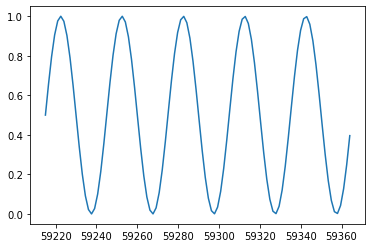

In [12]:
#times = ['2021-01-01T00:00:00.00', '2022-01-05T00:00:00.000']
#t = Time(times, format='isot', scale='utc')
times = ['59215', '59364']
t = Time(times, format='mjd') 
temporal_model.plot(t)